# 量子SDK TKET

## 0. 今日の量子コンピュータの問題

- Noisy Intermediate-Scale Quantum (NISQ) デバイス
    - 量子回路が深くなる（ゲート数が多くなる）ほど、誤差が大きくなる
    - 十分な量子ビット数ではない
- 量子デバイスは特別なゲート演算のみが用意されている
- 特定のqubits間の量子ビット演算(multi qubit operation)しか用意されていない
- それぞれの量子デバイスに対して、量子ソフトウェアツールキットが用意されてる


### 0-1. TKETとは
- Quantum Software Development Kit
- C++で実装
- pythonモジュール　`pytket`で利用可能
- 最適化コンパイラ：　ユーザーフレンドリーな回路→量子デバイスで実行可能な回路に変換可能
    - Language-agnostic (多くの量子プログラミングフレームワーク(qiskit, Cirq, etc)をサポート)
    - Retagetable (多くの量子デバイス(IBM Quantum, Quantinuum, AWS Braket, etc)をサポート)
    - Circuit Optimisation (量子計算時に生じるデバイスエラーの影響を最小化。デバイス依存＆デバイス非依存のものが実装)
    
<img src="fig/tket1.png" width="750">



#### 参照
- [pytket ドキュメント](https://cqcl.github.io/tket/pytket/api/index.html)
- [pytket ユーザーマニュアル](https://cqcl.github.io/pytket/manual/index.html)
- [t|ket⟩ : A Retargetable Compiler for NISQ Devices](https://arxiv.org/abs/2003.10611)

### 0-2. 今回必要となる python パッケージ
Python 3.9.7で動作確認をしています。

|  パッケージ （version） |  概要  |
| :---- | :---- |
|  pytket  |  tketを利用するためのpython モジュール  ( available for python3.8 or higher )|
|  pytket-qiskit  |  qiskitを利用するためのpytket-extension  |
|  pytket-braket  |  braketを利用するためのpytket-extension  |
|  pytket-qshapr  |  qsharpを利用するためのpytket-extension  |


<img src="fig/tket2.png" width="750">

環境にインストールされていない場合は、以下のセルの＃を取り除き、インストールしてください。

In [ ]:
#!pip install pytket
#!pip install pytket-qiskit
#!pip install pytket-braket
#!pip install pytket-qsharp
#!pip install pylatexenc #可視化のためのパッケージ
#!pip install matplotlib

## 1. 量子回路を作成する
ここでは IBMの量子デバイスやシュミレーションを利用できる`qiskit`と`tket`でベル状態を作成する。

### 1-1. `qiskit`でベル状態を作成
$$ |\Psi\rangle = \frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$$

In [ ]:
from qiskit import QuantumCircuit

qs_bell = QuantumCircuit(2)
qs_bell.h(0)
qs_bell.cx(0,1)
qs_bell.measure_all()

qs_bell.draw('mpl')

In [ ]:
#from qiskit.tools.visualization import circuit_drawer
#circuit_drawer(qs_bell, output='mpl')

### 1-2. IBMが提供しているローカルシミュレータで計算

In [ ]:
from qiskit import assemble, Aer
from qiskit.visualization import plot_histogram

In [ ]:
#Aer.backends()

In [ ]:
ibm_sim = Aer.get_backend('aer_simulator')

In [ ]:
handle = ibm_sim.run(qs_bell, shots=1000)
counts = handle.result().get_counts()
plot_histogram(counts)

### 1-3. `tket`でベル状態を作成

In [ ]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter

bell = Circuit(2)
bell.H(0).CX(0,1)
bell.measure_all()

render_circuit_jupyter(bell)

### 1-4. `pytket-qiskit`でIBMが提供しているローカルシミュレータで計算

In [ ]:
from pytket.extensions.qiskit import AerBackend
backend = AerBackend()

handle = backend.process_circuit(bell, n_shots =1000)
result_counts = backend.get_result(handle).get_counts()
plot_histogram(result_counts)

## 2. 量子回路の変換
pytketでは
- qiskitで記述した量子回路(`qiskit.QuantumCircuit`)からtketの量子回路のクラスに変換が可能
- tketで記述した量子回路からqiskitの量子回路(`qiskit.QuantumCircuit`)のクラスに変換が可能
- tketで記述した量子回路と他の量子プログラミング言語での量子回路の交換が可能

参照：[pytket-extensions](https://cqcl.github.io/pytket-extensions/api/index.html) 

### 2-1. `qiskit`の量子回路から`tket`の量子回路に変換

In [ ]:
from pytket.extensions.qiskit import qiskit_to_tk

In [ ]:
bell2 = qiskit_to_tk(qs_bell)
bell2

In [ ]:
render_circuit_jupyter(bell2)

### 2-2. `tket`の量子回路から`qiskit`の量子回路に変換

In [ ]:
from pytket.extensions.qiskit import tk_to_qiskit

In [ ]:
qs_bell2 = tk_to_qiskit(bell)
qs_bell2

In [ ]:
qs_bell2.draw('mpl')

### 2-3. `braket`の量子回路から`tket`の量子回路に変換

In [ ]:
from pytket.extensions.braket import tk_to_braket
aws_bell2 = tk_to_braket(bell)[0]
print(aws_bell2)

### 2-4. `tket`の量子回路から`braket`の量子回路に変換

In [ ]:
from pytket.extensions.braket import braket_to_tk
bell3 = braket_to_tk(aws_bell2)
render_circuit_jupyter(bell3)

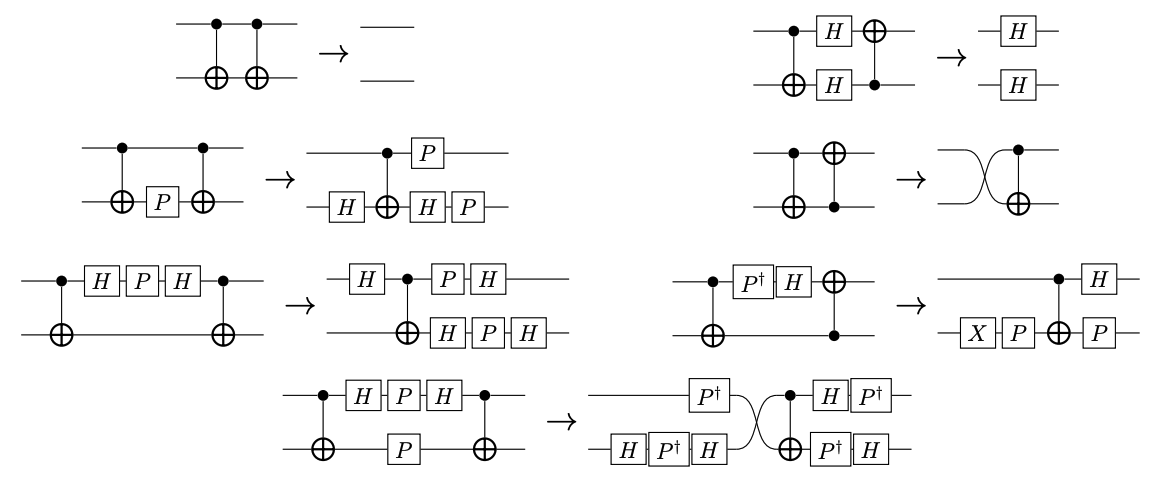## 3. 量子回路の最適化 Part1
例えば、Hゲートを同じビットに連続して作用させるとゲート操作をしていないのと恒等な量子状態が得られます。
<img src="fig/circ.png" width="500">

量子回路が深くなる（ゲート数が多くなる）ほど、誤差が大きくなるNISQ デバイスでは左辺のような状況は除去したい。

その他にも下記のような恒等な関係があります。
<img src="fig/relation.png" width="700">

### 3-1. `PauliSimp` 関数を利用した、量子回路の最適化
tketには量子回路を最適化する様々な機能が用意されている。
ここでは、`PauliSimp` 関数を利用した回路の最適化を行う。

（`PauliSimp` 関数：Pauli ゲートとCliffordゲートで表現された量子回路を出力）

ランダムな量子回路を作成し、回路の深さとCXの深さを数える。

In [ ]:
from pytket.pauli import Pauli
from pytket.circuit import PauliExpBox, fresh_symbol, OpType
from pytket.passes import DecomposeBoxes
box = PauliExpBox([Pauli.I, Pauli.Z, Pauli.X, Pauli.Y], fresh_symbol('tm'))
from pytket.utils import Graph
import numpy as np

def get_random_pauli_gadgets(n_qubits, n_pauli_gadgets, max_entangle):
    """ """
    paulis = [Pauli.I, Pauli.X, Pauli.Y, Pauli.Z]
    circ = Circuit(n_qubits)
    for i in range(n_pauli_gadgets):
        ls_paulis = [np.random.choice(paulis) for k in range(max_entangle)]
        if ls_paulis.count(Pauli.Y) % 2 == 0:
            continue
        if len(ls_paulis) - ls_paulis.count(Pauli.I) <= 1:
            continue
        qubits = np.random.choice(
            [i for i in range(n_qubits)], size=max_entangle, replace=False
        )
        box = PauliExpBox(ls_paulis, fresh_symbol('a'))
        circ.add_pauliexpbox(box, sorted(qubits))
    DecomposeBoxes().apply(circ)
    return circ

circ = get_random_pauli_gadgets(
    n_qubits=8, n_pauli_gadgets=300, max_entangle=5
)
print('Circuit depth: ', circ.depth())
print('CX depth: ', circ.depth_by_type(OpType.CX))
render_circuit_jupyter(circ)

`PauliSimp` 関数を使って、量子回路の最適化

In [ ]:
# Circuit optimization by using compiler passes.
from pytket.passes import PauliSimp
circx = circ.copy()
PauliSimp().apply(circx)
#FullPeepholeOptimise().apply(circx)
print('Circuit depth: ', circx.depth())
print('CX depth: ', circx.depth_by_type(OpType.CX))
#render_circuit_jupyter(circx)

`PauliSquash` 関数を使って、量子回路の最適化

In [ ]:
# Circuit optimization by using compiler passes.
from pytket.passes import PauliSquash
circy = circx.copy()
PauliSquash().apply(circy)
print('Circuit depth: ', circy.depth())
print('CX depth: ', circy.depth_by_type(OpType.CX))
#render_circuit_jupyter(circy)

## 4. pytket-extensionで、量子回路を量子デバイス・シミュレータで実行


### 4-1. pytket-qiskitを利用して、IBM Quantumのシミュレータや実機にアクセス

#### a. IBM Quantum へのアクセス設定

In [ ]:
path = 'key/ibm-token'
f = open(path)
ibm_token = f.read()
f.close()
from pytket.extensions.qiskit.backends.config import set_ibmq_config
set_ibmq_config(ibmq_api_token=ibm_token)

In [ ]:
from qiskit import IBMQ
IBMQ.save_account(ibm_token, overwrite=True)
from pytket.extensions.qiskit.backends.config import set_ibmq_config
set_ibmq_config(ibmq_api_token=ibm_token,hub="ibm-q",group="open",project="main")

In [ ]:
from pytket.extensions.qiskit import IBMQBackend, IBMQEmulatorBackend, AerBackend
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter

In [ ]:
list_backend=IBMQBackend.available_devices()
for dev in list_backend:
    print(dev.device_name)

#### b. backendの選択

In [ ]:
# ibm_backend = AerBackend()
# ibm_backend = IBMQBackend("ibmq_quito",token=ibm_token)
ibm_backend = IBMQBackend("ibmq_qasm_simulator",token=ibm_token)
# AerBackend to emulate the behaviour of IBMQBackend. Requires a valid IBMQ account.
# ibm_backend = IBMQEmulatorBackend("ibmq_quito",token=ibm_token)

#### c. backendのゲートセットに書き換える
`Backend.get_compiled_circuit(Circuit)`

In [ ]:
bell = Circuit(2)
bell.H(0).CX(0,1)
bell.measure_all()
render_circuit_jupyter(bell)

ibm_bell = ibm_backend.get_compiled_circuit(bell)
render_circuit_jupyter(ibm_bell)

#### d. 選択したbackendに量子回路を送信して実行させる

In [ ]:
ibm_handle = ibm_backend.process_circuit(ibm_bell, n_shots =1000)

In [ ]:
ibm_result = ibm_backend.get_result(ibm_handle)

In [ ]:
#ibm_backend.cancel(ibm_handle)

#### e. 結果の表示

In [ ]:
counts = ibm_result.get_counts()
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

IBM Quantumのシミュレータや実機で実行させた結果には、クラウド内でhandle_idが付与されている。

In [ ]:
print(str(ibm_handle))
handle_id = str(ibm_handle)

#### f. `ResultHandle`を使用して、handle_idの結果を呼び出す

#### handle_idで呼び出す結果で利用した量子デバイス・シミュレータをbackendとして選択

In [ ]:
from pytket.extensions.qiskit import IBMQBackend
#ibm_backend = IBMQBackend("ibmq_quito",token=ibm_token)
ibm_backend = IBMQBackend("ibmq_qasm_simulator",token=ibm_token)

In [ ]:
from pytket.backends import ResultHandle
handle = ResultHandle.from_str(handle_id)

#### 結果を表示

In [ ]:
result = ibm_backend.get_result(handle)
counts = result.get_counts()
print(counts)
#from qiskit.visualization import plot_histogram
#plot_histogram(counts)

### 4-3-A. 4-1, 4-2で実施したことは、その他の量子デバイス、クラウド量子コンピュータでも同様に可能 -Amazon Braket編

下記のスクリプトはAmazon Braketで<span style="color: red; ">有料</span>の操作を含んでおりますので、ご注意ください。

#### a. AWS へのアクセス設定

In [ ]:
path = 'key/aws-key'
f = open(path)
aws_access_key_id, aws_secret_access_key, s3_name, bucket_key= [s.strip() for s in f.readlines()]
f.close()

In [ ]:
import boto3
from braket.aws import AwsSession
boto_session = boto3.Session(
    aws_access_key_id= aws_access_key_id,
    aws_secret_access_key= aws_secret_access_key,
##    region_name= 'us-east-1'
##    region_name= 'us-west-1'
    region_name= 'eu-west-2'
)
## us-east-1: IonQ, Simulators (haven't support Xanadu yet)
## us-west-1: Rigetti, Simulators
## eu-west-2: Lucy, Simulators
##
aws_session = AwsSession(boto_session=boto_session)

In [ ]:
aws_session.search_devices()

#### ※Sagemaker Studio(imageはpython3.8以上のものを選択)にpytketをpip installしていただければ、下記のスクリプトでBraketへアクセスが可能です。
Sagemaker StudioからBraketにアクセス権限がない場合には、AWSシステム担当者にご連絡ください。

In [ ]:
#import boto3
#from braket.aws import AwsSession
#boto_session = boto3.Session(
#    region_name= 'us-east-1' #regionは'us-east-1','us-west-1','eu-west-2'の中から適切なものを選択してください。
#)
#aws_session = AwsSession(boto_session=boto_session)
#s3_name = aws_session.default_bucket()
#bucket_key = 'pytket'

#### b. backendの選択

In [ ]:
from pytket.extensions.braket import BraketBackend

# ionQ   arn:aws:braket:::device/qpu/ionq/ionQdevice, region: us-east-1
# aws_backend = BraketBackend(device='ionQdevice', s3_bucket=s3_name , s3_folder = bucket_key, device_type = 'qpu', provider = 'ionq', aws_session=aws_session)
# Aspen-M-2   arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-2 #Aspen-M-2, region: us-west-1
# aws_backend = BraketBackend(device='Aspen-M-2',region = 'us-west-1', s3_bucket=s3_name , s3_folder = bucket_key, device_type = 'qpu', provider = 'rigetti', aws_session=aws_session)
# Aspen-11   arn:aws:braket:::device/qpu/rigetti/Aspen-11 #Aspen-11, region: us-west-1
# aws_backend = BraketBackend(device='Aspen-11', s3_bucket=s3_name , s3_folder = bucket_key, device_type = 'qpu', provider = 'rigetti', aws_session=aws_session)
# Oxford Lucy   arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy #Lucy, region: eu-west-2
# aws_backend = BraketBackend(device='Lucy',region = 'eu-west-2', s3_bucket=s3_name , s3_folder = bucket_key, device_type = 'qpu', provider = 'oqc', aws_session=aws_session)
# SV1    sim_arn = 'arn:aws:braket:::device/quantum-simulator/amazon/sv1'     #SV1, region:
# aws_backend = BraketBackend(device='sv1', s3_bucket=s3_name , s3_folder = bucket_key, device_type = 'quantum-simulator', provider = 'amazon', aws_session=aws_session)
# TN1   sim_arn = 'arn:aws:braket:::device/quantum-simulator/amazon/tn1'    #TN1, region: us-west-2, us-east-1
# aws_backend = BraketBackend(device='tn1', s3_bucket=s3_name , s3_folder = bucket_key, device_type = 'quantum-simulator', provider = 'amazon', aws_session=aws_session)
# DM1   sim_arn = 'arn:aws:braket:::device/quantum-simulator/amazon/dm1'    #DM1, region: 
# aws_backend = BraketBackend(device='dm1', s3_bucket=s3_name , s3_folder = bucket_key, device_type = 'quantum-simulator', provider = 'amazon', aws_session=aws_session)
# Local SV1 simulator
aws_backend = BraketBackend(local = True, local_device='braket_sv')
# Local DM1 simulator
# aws_backend = BraketBackend(local = True, local_device='braket_dm')


#### c. backendのゲートセットに書き換える
`Backend.get_compiled_circuit(Circuit)`

In [ ]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter
# bell状態の作成
bell = Circuit(2)
bell.H(0).CX(0,1)
bell.measure_all()
render_circuit_jupyter(bell)

# backend に用意されているゲートで量子回路を表現
aws_bell = aws_backend.get_compiled_circuit(bell)
render_circuit_jupyter(aws_bell)

#### d. 選択したbackendに量子回路を送信して実行させる

In [ ]:
aws_handle = aws_backend.process_circuit(aws_bell, n_shots =100)
aws_result = aws_backend.get_result(aws_handle)

#### e. 結果の表示

In [ ]:
aws_counts = aws_result.get_counts()
print(aws_counts)
#from qiskit.visualization import plot_histogram
#plot_histogram(aws_result.get_counts())

In [ ]:
print(str(aws_handle))
handle_id = str(aws_handle)

#### f. `ResultHandle`を使用して、handle_idの結果を呼び出す

#### handle_idで呼び出す結果で利用した量子デバイス・シミュレータをbackendとして選択

In [ ]:
from pytket.backends import ResultHandle
handle = ResultHandle.from_str(handle_id)

In [ ]:
result = aws_backend.get_result(handle)
print(result.get_counts())
#from qiskit.visualization import plot_histogram
#plot_histogram(aws_result.get_counts())

### 4-3-B. 4-1, 4-2で実施したことは、その他の量子デバイス、クラウド量子コンピュータでも同様に可能 -Azure Quantum編

#### a. Azure へのアクセス設定はスキップ
- pytket-qsharpをインストールする前に、dotnetのインストールをしていただく必要がある。  
- Azure Quantum notebookからであれば、dotnetのインストールは事前にされているので, pip installでpytket, pytket-qsharpをインストールして頂ければ利用可能。

#### b. backendの選択

In [ ]:
from pytket.extensions.qsharp import AzureBackend, QsharpSimulatorBackend
# QsharpiSmulator
qsharp_backend = QsharpSimulatorBackend()
# Quantinuum H1 device
#azure_backend = AzureBackend(target_name='quantinuum.qpu.h1-1',resourceId='your_resource_id',location = "your_location")
#azure_backend = AzureBackend(target_name='quantinuum.qpu.h1-2',resourceId='your_resource_id',location = "your_location")
# Quantinuum H1 Syntax Checker
#azure_backend = AzureBackend(target_name='quantinuum.sim.h1-1sc',resourceId='your_resource_id',location = "your_location")
#azure_backend = AzureBackend(target_name='quantinuum.sim.h1-2sc',resourceId='your_resource_id',location = "your_location")
# Quantinuum H1 emulator
#azure_backend = AzureBackend(target_name='quantinuum.sim.h1-1e',resourceId='your_resource_id',location = "your_location")
#azure_backend = AzureBackend(target_name='quantinuum.sim.h1-2e',resourceId='your_resource_id',location = "your_location")

# IonQ device
#azure_backend = AzureBackend(target_name='ionq.qpu',resourceId='your_resource_id',location = "your_location")
#azure_backend = AzureBackend(target_name='ionq.qpu.aria-1',resourceId='your_resource_id',location = "your_location")
# IonQ simulator
# azure_backend = AzureBackend(target_name='ionq.simulator',resourceId='your_resource_id',location = "your_location")

#### c. backendのゲートセットに書き換える
`Backend.get_compiled_circuit(Circuit)`

In [ ]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter
# bell状態の作成
bell = Circuit(2)
bell.H(0).CX(0,1)
bell.measure_all()
render_circuit_jupyter(bell)

# backend に用意されているゲートで量子回路を表現
qsharp_bell = qsharp_backend.get_compiled_circuit(bell)
render_circuit_jupyter(qsharp_bell)

#### d. 選択したbackendに量子回路を送信して実行させる

In [ ]:
qsharp_handle = qsharp_backend.process_circuit(qsharp_bell, n_shots =200)
qsharp_result = qsharp_backend.get_result(qsharp_handle)

#### e. 結果の表示

In [ ]:
qsharp_counts = qsharp_result.get_counts()
print(qsharp_counts)
#from qiskit.visualization import plot_histogram
#plot_histogram(qsharp_result.get_counts())